In [1]:
import tensorflow as tf

In [2]:
import os
os.getcwd()

'C:\\Users\\LV\\Desktop\\LV Personal\\super-resolution'

In [4]:
os.chdir("C:\\Users\\LV\\Desktop\\LV Personal\\super-resolution")

In [5]:

import matplotlib.pyplot as plt

from data import DIV2K
from model.gan import generator, discriminator
from trainnew import SrganTrainer, SrganGeneratorTrainer

%matplotlib inline

In [6]:
# Location of model weights (needed for demo)
weights_dir = 'weights/srgan'
weights_file = lambda filename: os.path.join(weights_dir, filename)

os.makedirs(weights_dir, exist_ok=True)

In [ ]:
div2k_train = DIV2K(scale=4, subset='train', downgrade='bicubic')
div2k_valid = DIV2K(scale=4, subset='valid', downgrade='bicubic')

train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=16, repeat_count=1, random_transform=True)

In [0]:

pre_trainer = SrganGeneratorTrainer(model=generator(), checkpoint_dir=f'.ckpt/pre_generator')
pre_trainer.train(train_ds,
                  valid_ds.take(10),
                  steps=10000, 
                  evaluate_every=1000, 
                  save_best_only=False)

pre_trainer.model.save_weights(weights_file('pre_generator.h5'))

In [7]:
gan_generator = generator()
gan_generator.load_weights(weights_file('pre_generator.h5'))

gan_trainer = SrganTrainer(generator=gan_generator, discriminator=discriminator())
gan_trainer.train(train_ds, steps=10000)

NameError: name 'train_ds' is not defined

In [0]:
gan_trainer.generator.save_weights(weights_file('gan_generator.h5'))
gan_trainer.discriminator.save_weights(weights_file('gan_discriminator.h5'))

In [7]:
pre_generator = generator()
gan_generator = generator()

pre_generator.load_weights(weights_file('pre_generator.h5'))
gan_generator.load_weights(weights_file('gan_generator.h5'))

In [8]:
from model.functions import resolve_single
from trainnew import load_image

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    
    pre_sr = resolve_single(pre_generator, lr)
    gan_sr = resolve_single(gan_generator, lr)
    
    plt.figure(figsize=(20, 20))
    
    images = [lr, pre_sr, gan_sr]
    titles = ['LR', 'SR (PRE)', 'SR (GAN)']
    positions = [1, 3, 2]
    
    for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, pos)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

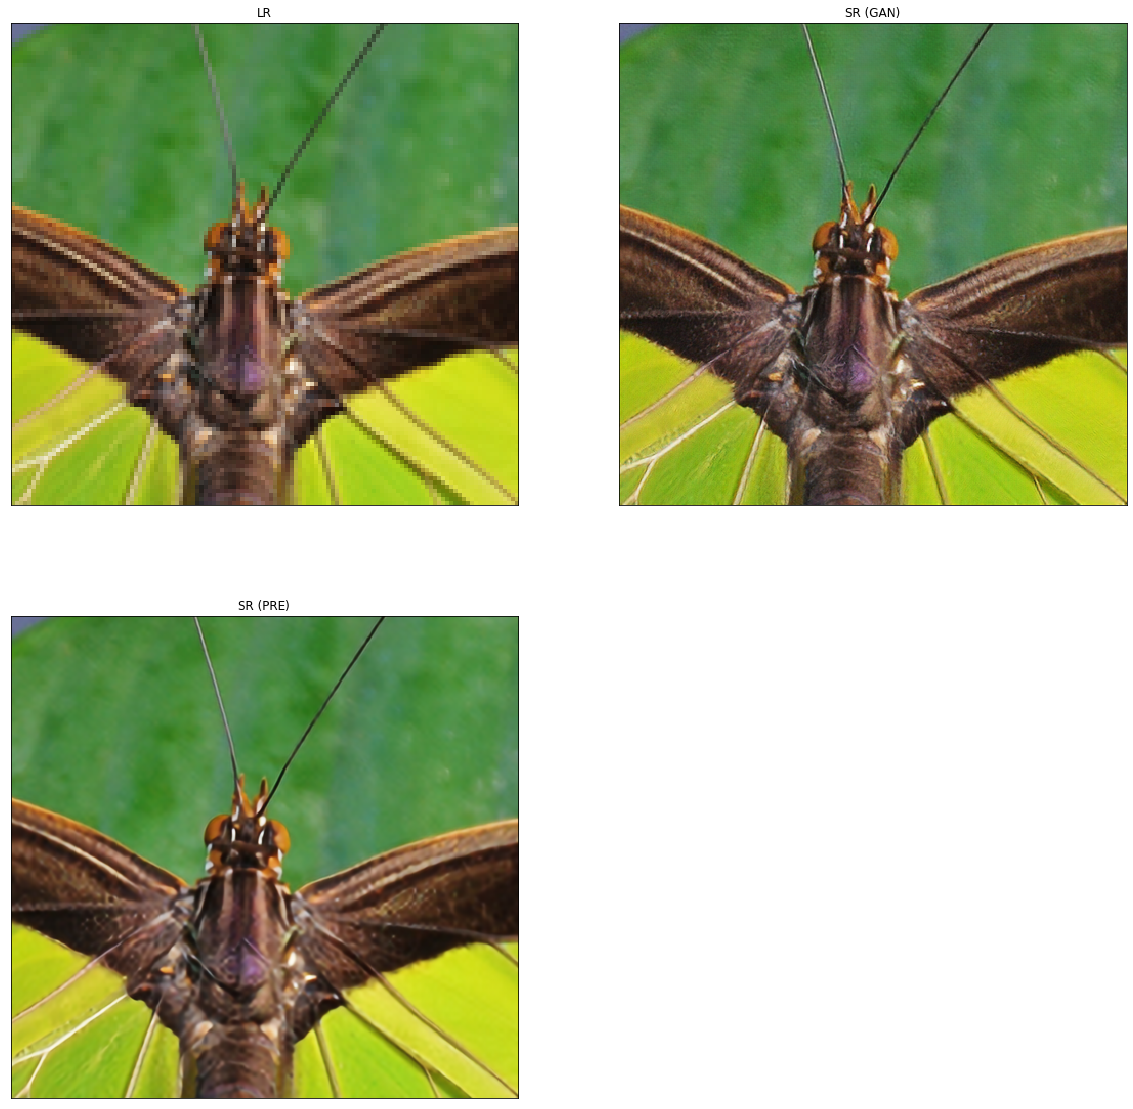

In [9]:
resolve_and_plot('demo/0829x4-crop.png')

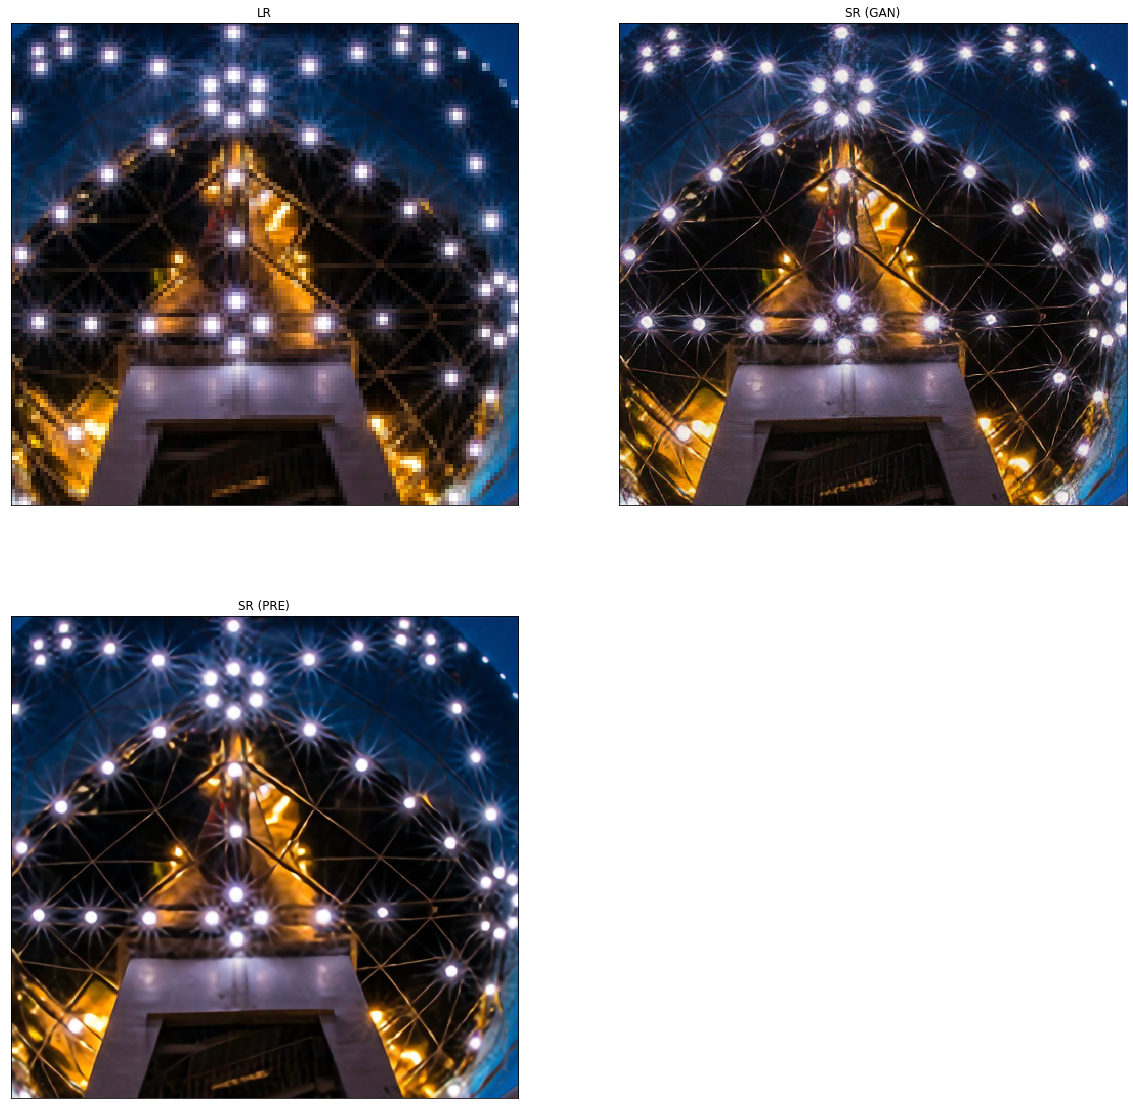

In [10]:
resolve_and_plot('demo/0851x4-crop.png')

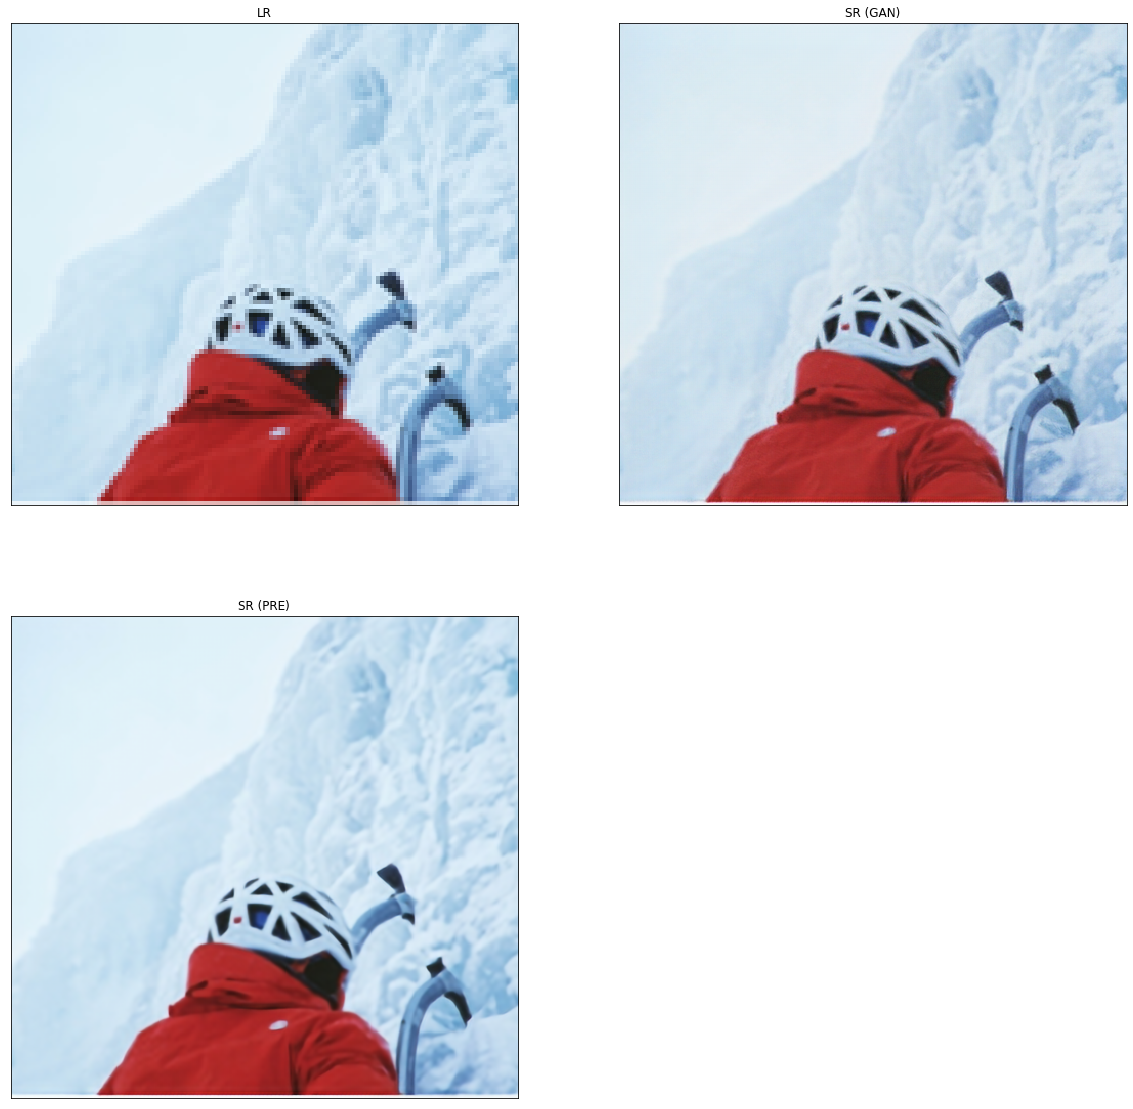

In [11]:
resolve_and_plot('demo/ice_climb.png')

In [12]:
pip show opencv-python

Name: opencv-python
Version: 4.2.0.34
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: None
Author-email: None
License: MIT
Location: c:\users\lv\anaconda3\lib\site-packages
Requires: numpy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [13]:
from tqdm import tqdm
import cv2
import numpy as np
from PIL import Image

In [14]:
def video_resolve(path_to_video) : 
    cap = cv2.VideoCapture(path_to_video)

    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    #videowriter arguments
    codec = "FMP4"
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    print("fps=",fps)

    fourcc = cv2.VideoWriter_fourcc(*codec)
    writer = cv2.VideoWriter('gan_write.3gp', fourcc, fps,(496 , 472), False)

    for i in tqdm(range(0, num_frames)):
        ret, frame = cap.read()  # read a frame

        gan_sr = resolve_single(gan_generator, frame)
        tf.keras.preprocessing.image.save_img('SR_frames/frame_{}.png'.format(i+1),gan_sr)
        
        #print(type(gan_sr.numpy()))
        if writer is not None:
                plt.imshow(gan_sr.numpy())
                name = './LR_frames/frame_' + str(i) + '.png'
                cv2.imwrite(name, frame)
        

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
    # cleanup
    cap.release()
    cv2.destroyAllWindows()


  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

fps= 15


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [01:06<00:00,  1.36s/it]


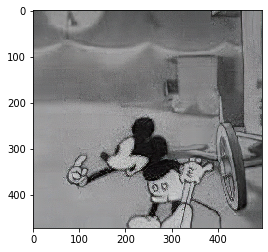

In [15]:
video_resolve('demo/lvgan_demo_3.3gp')

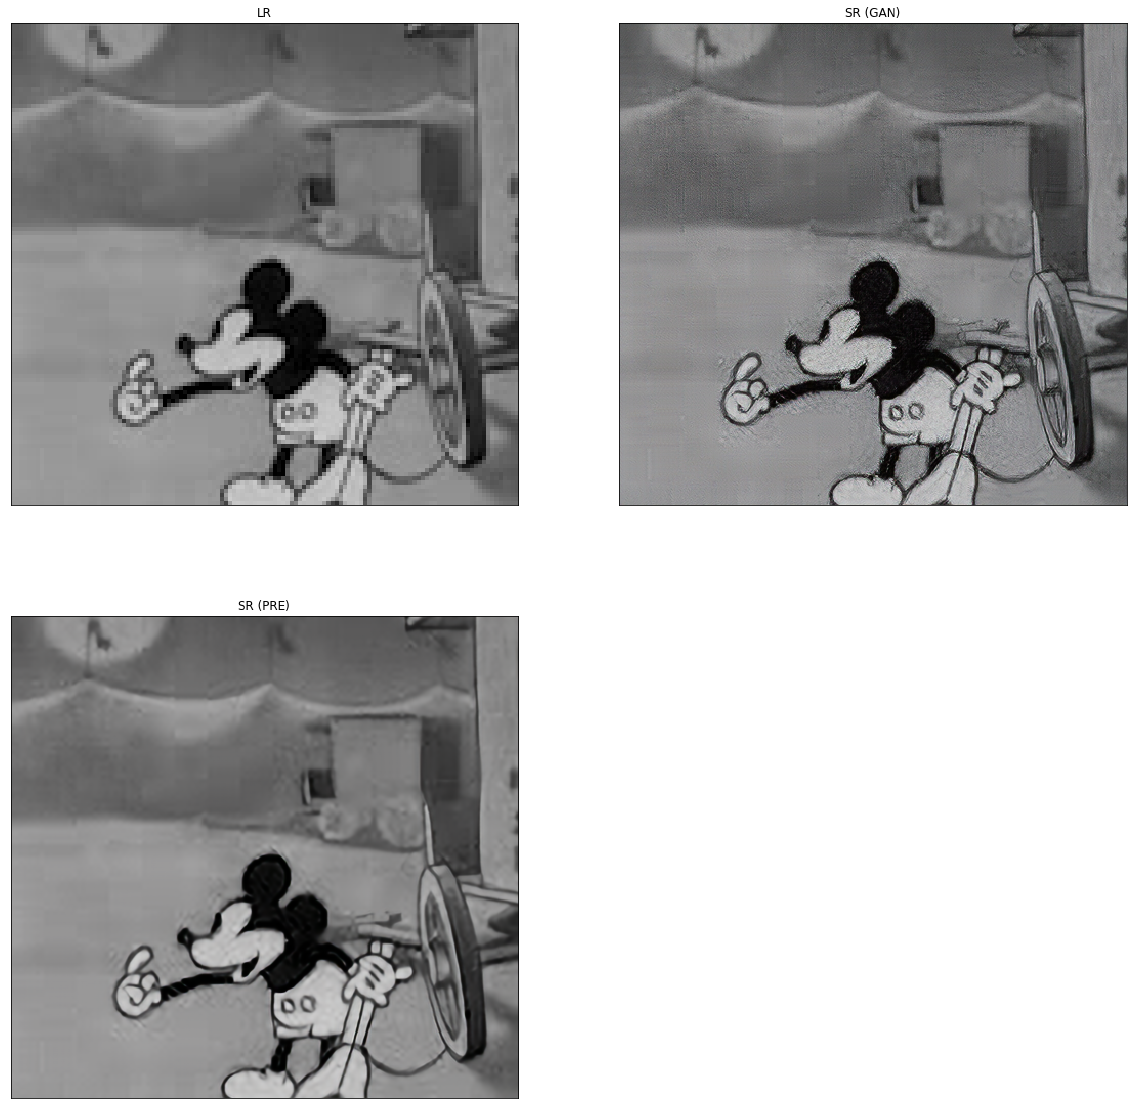

In [16]:
resolve_and_plot('LR_frames/frame_37.png')

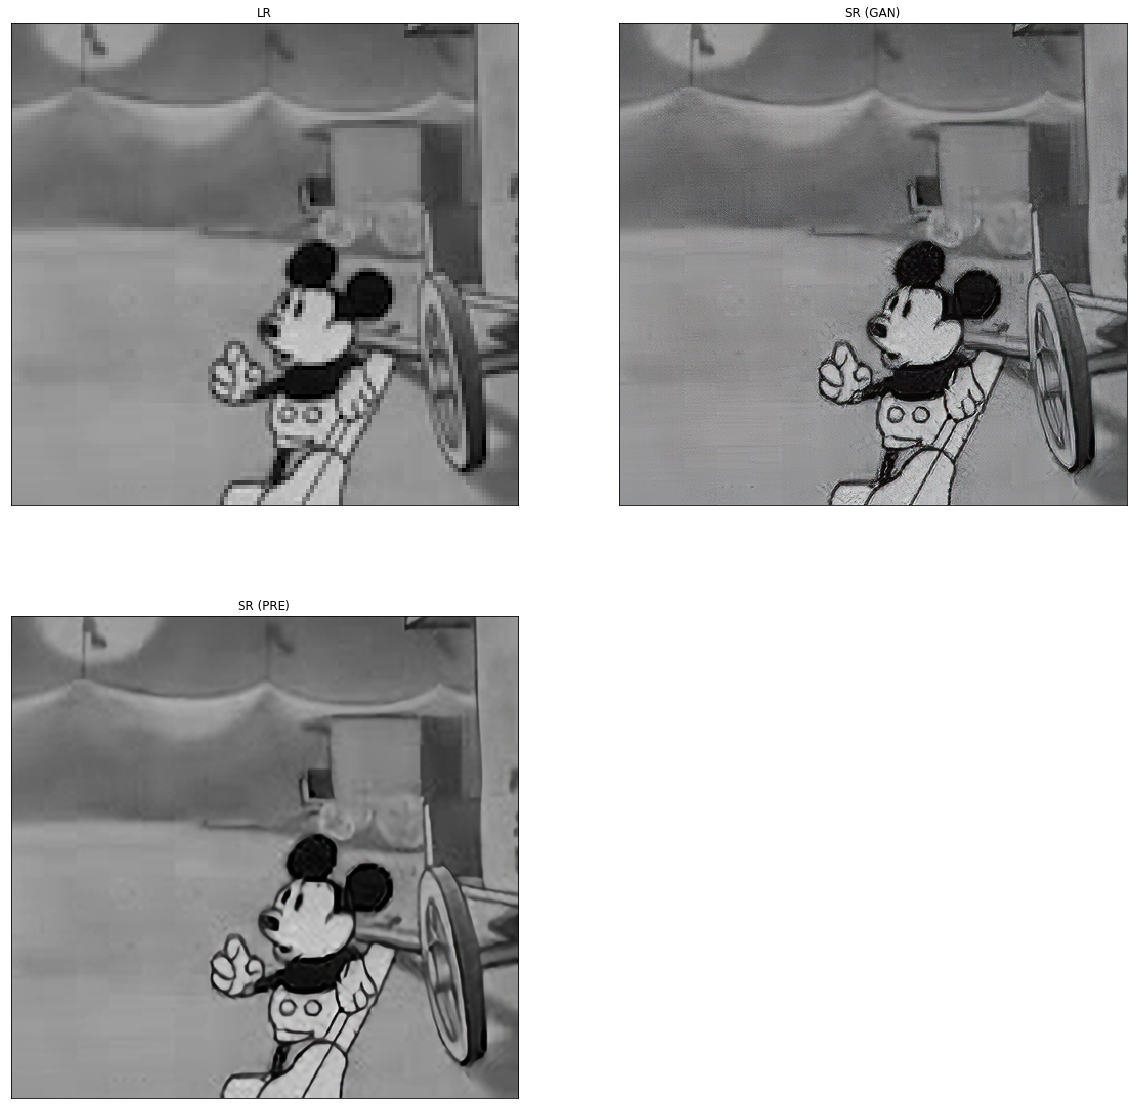

In [8]:
resolve_and_plot('LR_frames/frame_2.png')

In [29]:
def generate_video(): 
    image_folder = 'SR_frames'
    video_name = 'GANgeneratedvideo.avi'
     
      
    images = [img for img in os.listdir(image_folder) 
              if img.endswith("png")] 
     
    num_frames = len(images)
    video = cv2.VideoWriter(video_name, 0, 15, (496, 472))
    
  
    # Appending the images to the video one by one 
    for i in tqdm(range(0, num_frames)):  
        video.write(cv2.imread(os.path.join('SR_frames/frame_{}.png'.format(i+1))))  
      
    cv2.destroyAllWindows()  
    video.release()  
  
  
# Calling the generate_video function 
generate_video() 

100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 171.79it/s]
